In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from source.tserie import TSerie
from source.featlearn.tdr import TDR
from source.torch_utils import getContrastiveFeatures
from source.read_ontario import read_ontario
from source.read_india import read_india
from source.read_brasil import read_brasil
from source.utils import commonWindows
from cuml.manifold import UMAP

import sys

sys.path.append('/home/texs/Documentos/Repositories/ts2vec')
from ts2vec import TS2Vec
# from cuml.manifold import UMAP

N_VIZ_SAMPLES = 600
VIS_PATH = 'visualizations'
SMOOTH = 8 # 8 -1 if you don't want to smooth the data otherwise the size of the smooth window
MODE = 'shape' # subsequences - shape
EPOCHS = 40
POLLUTANTS = ['MP25', 'O3', 'NOx'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
# all_fileNames = ['BEN', 'CO', 'DV', 'DVG', 'ERT', 'MP10', 'MP25', 'NO', 'MP25', 'NOx', 'O3', 'PRESS', 'RADG', 'RADUV', 'SO2', 'TEMP', 'TOL', 'UR']
UMAP_NEIGHBORS = 15



/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
windows_map = read_brasil(granularity='months', cache=True)

windows, dates, station_ids, stations = commonWindows(windows_map, POLLUTANTS)

/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/numpy/lib/format.py:748: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  array = pickle.load(fp, **pickle_kwargs)


In [3]:
month_ids = np.array([date.month for date in dates])
year_ids = np.array([date.year for date in dates])

stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, len(month_ids) + 1)}
years_map = {int(year) : str(year) for year in year_ids}

mts = TSerie(X=windows, y =station_ids)

mts.smooth(window_size=8)
# mts.shapeNormalizization()
mts.minMaxNormalizization()

Loaded mts - N: 164, T: 28, D: 3 
(164, 3, 28)


([2.0625, 1.5266800629258608, 2.3043478260869565],
 [55.70833333333333, 97.70345517556667, 309.99745155614784])

In [4]:
from sklearn.decomposition import PCA
from cuml.neighbors import NearestNeighbors
from cuml.manifold import UMAP


class TS2VecModel:
    def __init__(self, output_dims):
        self.output_dims = output_dims
    
    def fit_transform(self, X, n_epochs):
        N, T, D = X.shape
        self.Drepr = np.zeros([N, D, self.output_dims])
        self.Trepr = np.zeros([N, D, T, self.output_dims])
        for i in range(D):
            model = TS2Vec(
                input_dims=1,
                device=0,
                output_dims=self.output_dims,
                
            )
            Xi = np.expand_dims(X[:, :, i], axis=2)
            model.fit(Xi, verbose=True,n_epochs = n_epochs)
            self.Drepr[:, i, :] =  model.encode(Xi, encoding_window='full_series')
            self.Trepr[:, i, :, :] = model.encode(Xi)
            
        self.Dvals = np.zeros([N, D])
        # self.Tvals = np.zeros([N, D])
        for i in range(D):
            reducer = PCA(n_components=1)
            self.Dvals[:, i] =reducer.fit_transform(self.Drepr[:, i, :]).flatten()
            
        return self.Drepr.reshape([N, D * self.output_dims])

class UMAP_FL:
    def __init__(self, n_components, n_neighbors, metric = 'braycurtis', n_epochs = 1000):
        self.reducer = UMAP(n_components=n_components, n_neighbors=n_neighbors, n_epochs=n_epochs)
        self.nearNeigh = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)

    def fit_transform(self, X, y=None):
        self.nearNeigh.fit(X)
        knn_graph = self.nearNeigh.kneighbors_graph(X, mode="distance")
        embeddings =  self.reducer.fit_transform(X, y=y, knn_graph=knn_graph.tocsr(), convert_dtype=True)
        return embeddings
    
    def transform(self, X):
        knn_graph = self.nearNeigh.kneighbors_graph(X, mode="distance")
        embeddings =  self.reducer.transform(X, knn_graph=knn_graph.tocsr(), convert_dtype=True)
        return embeddings

# class UMAP_CONT:
#     def __init__(self, n_components, n_neighbors, metric = 'braycurtis', n_epochs = 1000):
#         self.reducer = UMAP(n_components=n_components, n_neighbors=n_neighbors, n_epochs=n_epochs)
#         self.nearNeigh = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)

#     def fit_transform(self, X, y=None):
#         self.nearNeigh.fit(X)
#         knn_graph = self.nearNeigh.kneighbors_graph(X, mode="distance")
#         embeddings =  self.reducer.fit_transform(X, y=y, knn_graph=knn_graph.tocsr(), convert_dtype=True)
#         return embeddings
    
#     def transform(self, X):
#         knn_graph = self.nearNeigh.kneighbors_graph(X, mode="distance")
#         embeddings =  self.reducer.transform(X, knn_graph=knn_graph.tocsr(), convert_dtype=True)
#         return embeddings

In [5]:
# model = TS2VecModel(4)
# mts.features = model.fit_transform(mts.X, n_epochs = 10)

model = UMAP_FL(n_components=10, n_neighbors=15, metric='euclidean')

mts.folding_features_v1()
mts.features = model.fit_transform(mts.features)

Features shape: (164, 84)


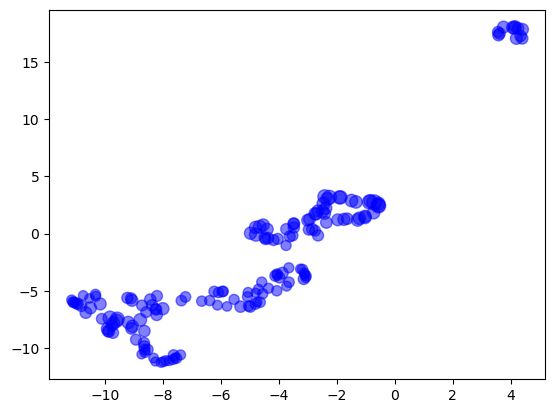

In [6]:
import matplotlib.pyplot as plt

reducer = UMAP(n_components=2, n_epochs=4000)
reducer.fit(mts.features)
coords = reducer.transform(mts.features)
min_r = 5
max_r = 80
magnitudes = mts.magnitudes[:, 0]
point_radius = ((magnitudes + magnitudes.min()) / (magnitudes.max() - magnitudes.min()) ) * (max_r - min_r) + min_r

plt.scatter(coords[:, 0], coords[:, 1], s = point_radius, color="blue", alpha=0.5)



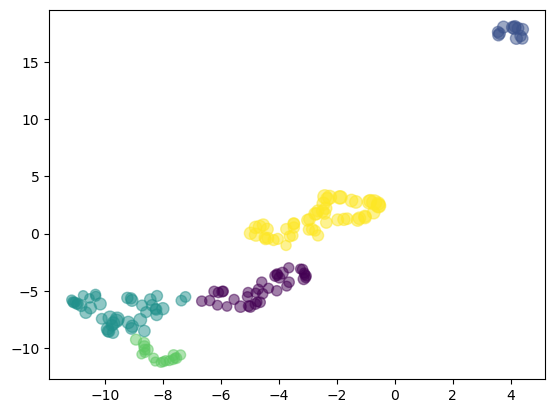

In [7]:
from sklearn.cluster import KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)

classes = kmeans.labels_
# clusters = np.unique(kmeans.labels_)s

# clusterLabels = 

plt.scatter(coords[:, 0], coords[:, 1], s = point_radius, c = classes, alpha=0.5)


In [8]:
print(mts.X.shape)
N, T, D = mts.X.shape

dim_compressed = np.zeros([N, T])
dim_data = []
for i in range(N):
    for j in range(T):
        dim_data.append(mts.X[i, j])
dim_data = np.array(dim_data)

dim_features = PCA(n_components=1).fit_transform(dim_data)

dim_features = np.reshape(dim_features, [N, T])
for i in range(N):
    for j in range(T):
        dim_compressed[i, j] = dim_features[i, j]

(164, 28, 3)


In [9]:
print(mts.X.shape)
N, T, D = mts.X.shape

time_compressed = np.zeros([N, D])
time_data = []
for i in range(N):
    for j in range(D):
        time_data.append(mts.X[i, :,  j])
time_data = np.array(time_data)
time_features = PCA(n_components=1).fit_transform(time_data)

time_features = np.reshape(time_features, [N, D])
for i in range(N):
    for j in range(D):
        time_compressed[i, j] = time_features[i, j]

(164, 28, 3)


In [10]:
from ccpca import CCPCA
from source.utils import folding_2D

groups = np.unique(classes)
group_ids = classes

fcs = []
for target in groups:
    ccpca = CCPCA(n_components=1)
    
    Xf = dim_compressed[group_ids==target]
    Xb = dim_compressed[group_ids!=target]
    ccpca.fit(
        Xf,
        Xb,
        var_thres_ratio=0.5,
        n_alphas=40,
        max_log_alpha=0.5,
    )
    coords2 = ccpca.transform(Xf)
    best_alpha = ccpca.get_best_alpha()
    cpca_fcs = ccpca.get_feat_contribs()
    fcs.append(cpca_fcs)

In [11]:
from ccpca import CCPCA
from source.utils import folding_2D

groups = np.unique(classes)
group_ids = classes

fcs_time = []
for target in groups:
    ccpca = CCPCA(n_components=1)
    
    Xf = time_compressed[group_ids==target]
    Xb = time_compressed[group_ids!=target]
    ccpca.fit(
        Xf,
        Xb,
        var_thres_ratio=0.5,
        n_alphas=40,
        max_log_alpha=0.5,
    )
    coords2 = ccpca.transform(Xf)
    best_alpha = ccpca.get_best_alpha()
    cpca_fcs = ccpca.get_feat_contribs()
    fcs_time.append(cpca_fcs)

<AxesSubplot:>

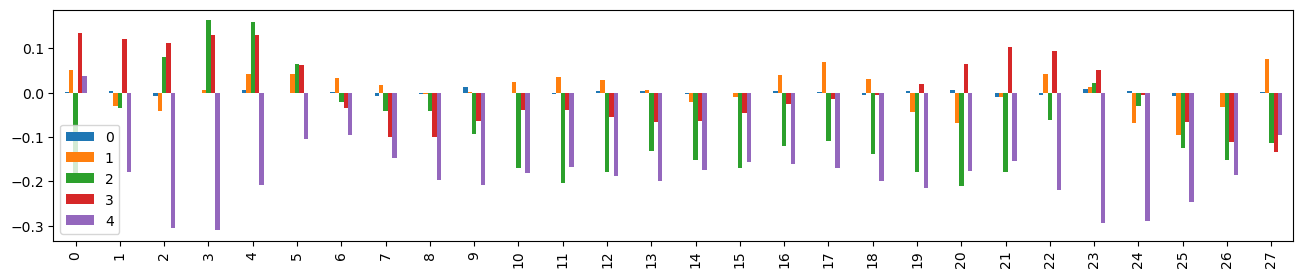

In [12]:
import pandas as pd
fcs = np.array(fcs)
fcsDf = pd.DataFrame(fcs.transpose(), index = np.arange(fcs.shape[1]))
fcsDf.plot( kind="bar", figsize=(16, 3))

<AxesSubplot:>

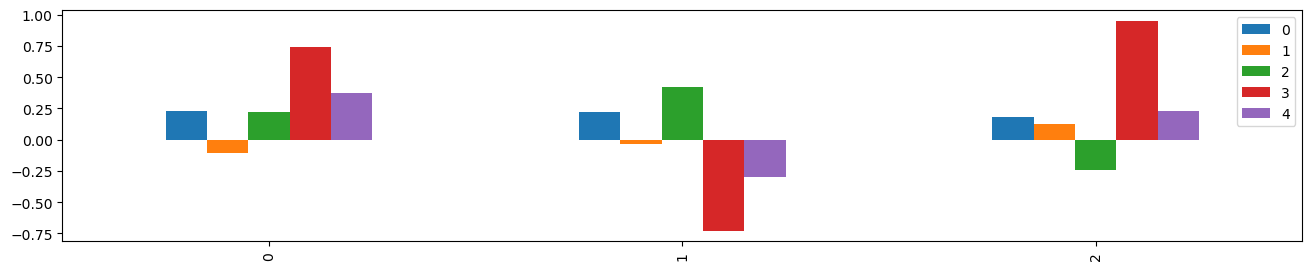

In [13]:
fcs_time = np.array(fcs_time)
fcsDf_time = pd.DataFrame(fcs_time.transpose(), index = np.arange(fcs_time.shape[1]))
fcsDf_time.plot( kind="bar", figsize=(16, 3))

In [14]:
from server.source.storage import MTSStorage

storage = MTSStorage(os.path.join(VIS_PATH ,'ts2vec.npy'))    
# storage.delete()
storage.load()

dimensions = POLLUTANTS
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    '_'.join(POLLUTANTS) , data , 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'station': station_ids, 'months': month_ids, 'years': year_ids, 'clusters': classes.astype(int)}, 
    labelsNames={'station': stations_map, 'months': months_map, 'years': years_map, 'clusters': {int(gr):str(gr) for gr in groups},  }, 
    coords = {
        'coords': coords,
    },
    sampling=True,
    n_samples= N_VIZ_SAMPLES
)

storage.save()

mts shape: N: 164 -  T: 28 - D: 6


In [15]:
classes_map = {int(gr):str(gr) for gr in groups}